## Gridsearch XGBoost balanced for arthritis severity classes

## imports

In [16]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
import warnings
import re
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from NHS_PROMs.load_data import load_proms, structure_name
from NHS_PROMs.preprocess import filter_in_range, filter_in_labels, method_delta
from NHS_PROMs.utils import (
    downcast,
    map_labels,
    fillna_categories,
    pd_fit_resample,
    infer_categories_fit,
    KindSelector,
    get_feature_names,
    remove_categories,
)
from NHS_PROMs.data_dictionary import meta_dict, methods

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.dummy import DummyClassifier
from sklearn.utils.class_weight import compute_sample_weight

# from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (
    ColumnTransformer,
    make_column_transformer,
    make_column_selector,
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingRegressor,
    BaggingClassifier,
)
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import set_config

from xgboost import XGBClassifier, XGBRFClassifier

set_config(display="diagram")

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler 

# use adjusted fillna which can cope with non-existing categories for CategoricalDtype
pd.core.frame.DataFrame.fillna = fillna_categories
# added a remove categories
pd.core.frame.Series.remove_categories = remove_categories
# enable autodetect of categories from CategoricalDtype by using "infer" for SMOTENC
SMOTENC.fit_resample = pd_fit_resample(SMOTENC.fit_resample)
# enable inference of categories for encoders from CategoricalDtype
OneHotEncoder.fit = infer_categories_fit(OneHotEncoder.fit)
OrdinalEncoder.fit = infer_categories_fit(OrdinalEncoder.fit)

SEED = 42

## load data
General approach is not DRY for the sake of availability of having knee and hip df's always at hand, but also keep it readable (script-wise).

In [2]:
# load data + rename columns with structired name
# df_knee_raw = load_proms(part="knee").apply(downcast).rename(structure_name, axis=1)
df_hip_raw = load_proms(part="hip").apply(downcast).rename(structure_name, axis=1)

# get meta data for each
full_meta = {t + k: v for k, v in meta_dict.items() for t in ["t0_", "t1_"]}
hip_meta = {k: v for k, v in full_meta.items() if k in df_hip_raw.columns}

df_hip_raw.sample(3)

,t0_provider_code,t0_procedure,t0_revision_flag,t0_year,t0_age_band,t0_gender,t0_assisted,t0_assisted_by,t0_symptom_period,t0_previous_surgery,...,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score,t1_ohs_predicted
22961,RJ2,Hip Replacement,0,2018/19,70 to 79,2.0,2,0,3,2,...,4,4,4,4,4,4,4,4,48.0,39.597141
32973,RTX,Hip Replacement,0,2017/18,60 to 69,2.0,2,0,3,2,...,4,2,4,4,3,2,3,3,34.0,37.803154
31600,RTG,Hip Replacement,0,2017/18,80 to 89,2.0,2,0,2,2,...,4,4,4,4,4,4,4,4,48.0,36.230515


## basic cleaning

In [3]:
%%time

endings = (
    "code", # is a coded score and not of interest for the case
    "procedure", # is the same for the hip or knee set
    "revision_flag", # revisions are out of scope, filtered away, so same for all rows after that
    "assisted_by", # is the same for all records
    "profile", # is a coded score and not of interest for the case
    "predicted", # are predictions of other models that are not supposed to be used
)
cols2drop = [c for c in df_hip_raw.columns if c.endswith(endings)]

df_hip_clean = (
    df_hip_raw.apply(lambda s: filter_in_range(s, **hip_meta[s.name])) # filter in range numeric features
    .apply(lambda s: filter_in_labels(s, **hip_meta[s.name])) # filter in labels categorical features + ordinal if ordered
    .apply(lambda s: map_labels(s, **hip_meta[s.name])) # map the labels as values for readability
    .query("t0_revision_flag == 'no revision'") # drop revision cases
    .drop(columns=cols2drop) # drop not needed columns
    .reset_index(drop=True) # make index unique (prevent blow ups when joining)
)

# remove NaNs/missing/unknown from numerical and ordinal features
df_hip_clean = (
    df_hip_clean.apply(pd.Series.remove_categories, args=(["missing", "not known"],))
    .dropna(subset= KindSelector(kind="numerical")(df_hip_clean) + KindSelector(kind="ordinal")(df_hip_clean))
)

df_hip_clean.sample(3)

CPU times: user 651 ms, sys: 64.2 ms, total: 715 ms
Wall time: 719 ms


,t0_year,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
89938,April 2018 - April 2019,70 to 79,male,no,1 to 5 years,no,with partner / spouse / family / friends,yes,yes,yes,...,rarely/never,sometimes or just at first,"often, not just at first",sometimes or just at first,sometimes or just at first,sometimes or just at first,rarely/never,rarely/never,sometimes or just at first,40.0
60248,April 2017 - April 2018,60 to 69,male,no,1 to 5 years,yes,with partner / spouse / family / friends,no,NaN,yes,...,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,48.0
7478,April 2016 - April 2017,60 to 69,male,no,1 to 5 years,no,with partner / spouse / family / friends,no,NaN,NaN,...,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,rarely/never,rarely/never,rarely/never,"often, not just at first",40.0


### Explanation why we can drop years

In [4]:
# def plot_year_histograms(t=0, method="eq5d"):
    
#     facet_cols = ["_".join([f"t{t}", method, dim]) for dim in methods[method]["dims"]["names"]]

#     df_plot = (
#         df_hip_clean[["t0_year"] + facet_cols]
#         .set_index("t0_year")
#         .stack()
#         .reset_index()
#         .set_axis(["year", "dimension", "value"], axis=1)
#     )

#     fig = px.histogram(
#         df_plot,
#         title=f"Distributions of values over the years for method {method} at t{t}",
#         x="value",
#         color="year",
#         barmode="group",
#         histnorm="percent",
#         facet_col="dimension",
#         facet_col_wrap=3,
#         category_orders={"value":list(methods[method]["dims"]["labels"].values())},
#     )

#     fig.update_xaxes(col=3, showticklabels=True, visible=True)
#     fig.update_layout(legend=dict(xanchor="right", x=1, yanchor="bottom", y=0))

#     fig.show()
    
# [plot_year_histograms(t=t) for t in [0, 1]];

## split data

In [5]:
# split train + test set
df_hip = df_hip_clean.query("t0_year != '2019/20'").drop(columns="t0_year")
df_hip_unseen = df_hip_clean.query("t0_year == '2019/20'").drop(columns="t0_year")

df_hip.sample(3)

,t0_age_band,t0_gender,t0_assisted,t0_symptom_period,t0_previous_surgery,t0_living_arrangements,t0_disability,t0_heart_disease,t0_high_bp,t0_stroke,...,t1_ohs_washing,t1_ohs_transport,t1_ohs_dressing,t1_ohs_shopping,t1_ohs_walking,t1_ohs_limping,t1_ohs_stairs,t1_ohs_standing,t1_ohs_work,t1_ohs_score
112132,70 to 79,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,NaN,NaN,NaN,...,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,sometimes or just at first,most of the time,sometimes or just at first,rarely/never,sometimes or just at first,37.0
35723,50 to 59,female,no,1 to 5 years,no,with partner / spouse / family / friends,NaN,NaN,NaN,NaN,...,rarely/never,rarely/never,rarely/never,sometimes or just at first,rarely/never,rarely/never,sometimes or just at first,sometimes or just at first,sometimes or just at first,40.0
97891,80 to 89,female,no,1 to 5 years,no,with partner / spouse / family / friends,yes,NaN,yes,NaN,...,sometimes or just at first,"often, not just at first",most of the time,all of the time,"often, not just at first",most of the time,most of the time,"often, not just at first",most of the time,20.0


In [6]:
# create x, y
X = df_hip.filter(regex="t0")
# # regression:
# y = df_hip["t1_ohs_score"] - df_hip["t0_ohs_score"]

# classification
#y_name = "t1_eq5d_discomfort"
#y_labels = {k:v for k, v, in enumerate(df_hip[y_name].cat.categories)}
#y = df_hip[y_name].cat.codes

# # make a smaller selection of our training data to play with
# X = X.iloc[:1000, :] # [0, 1, 2, 3, 4, -4, -3, -2, -1]]
# y = y.iloc[:1000]

y_temp = pd.cut(
     df_hip["t1_ohs_score"],
     bins=[0, 29, 39, 48],
     labels=["severe-moderate", "mild", "satisfactory"],
     include_lowest=True,
     )
    
y_labels = {k: v for k, v, in enumerate(y_temp.cat.categories)}
y = y_temp.cat.codes

# create train, test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=SEED, stratify=y)

In [7]:
# # for total / Laurence
# y_temp = pd.cut(
#     df_hip["t1_ohs_score"],
#     bins=[0, 29, 39, 48],
#     labels=["severe-moderate", "mild", "satisfactory"],
#     include_lowest=True,
# )
# y_labels = {k: v for k, v, in enumerate(y_temp.cat.categories)}
# y = y_temp.cat.codes
# y_temp.value_counts() / len(y_temp)

## make + train a simple pipeline

In [8]:
ct = ColumnTransformer(
    (
        ("numerical", StandardScaler(), KindSelector(kind="numerical")),
        (
            "categorical",
            OneHotEncoder(categories="categories", handle_unknown="ignore"),
            KindSelector(kind="categorical"),
        ),
        (
            "ordinal",
            OrdinalEncoder(categories="categories", handle_unknown="ignore"),
            KindSelector(kind="ordinal"),
        ),
    ),
    remainder="drop",
)

pl = Pipeline(
    (
        ("balancer", "passthrough"),
        ("by_column_kinds", ct),
        ("model", KNeighborsClassifier()),
    )
)

# train the pipeline/model
pl.fit(X_train, y_train)

Pipeline(steps=[('balancer', 'passthrough'),
                ('by_column_kinds',
                 ColumnTransformer(transformers=(('numerical', StandardScaler(),
                                                  <NHS_PROMs.utils.KindSelector object at 0x7f9c50570b50>),
                                                 ('categorical',
                                                  OneHotEncoder(categories='categories',
                                                                handle_unknown='ignore'),
                                                  <NHS_PROMs.utils.KindSelector object at 0x7f9c505739d0>),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories='categories',
                                                                 handle_unknown='ignore'),
                                                  <NHS_PROMs.utils.KindSelector object at 0x7f9c50573580>)))),
                ('model', KNeighborsClassifier())])

In [9]:
# get_feature_names(pl)

## Gridsearch

In [10]:
# implemented automatic weights in pl
class BalancedXGBRFClassifier(XGBRFClassifier):
    
    def fit(self, X, y, **kwargs):
        
        weights = compute_sample_weight(class_weight="balanced", y=y)
        kwargs.update({"sample_weight":weights})
        
        return super().fit(X, y, **kwargs)

In [11]:
%%time
# create parameter grid to search on 

# # standard same as pipeline
# param_grid = dict()

# kills warnings ;)
std_xgb_args = dict(
    n_estimators=100,
    use_label_encoder=False,
    objective="multi:softprob",
    eval_metric="mlogloss", 
)

# tuning different hyper parameters on different models
param_grid = [
    {
        "balancer": ["passthrough"],
        "model": [
            DummyClassifier(strategy="stratified"),
            BalancedBaggingClassifier(n_estimators=100),
            BalancedRandomForestClassifier(n_estimators=100),
            BalancedXGBRFClassifier(**std_xgb_args),
        ],
    },
    {
        "balancer": [RandomUnderSampler()],
        "model": [
            XGBRFClassifier(**std_xgb_args), 
            XGBClassifier(**std_xgb_args)],
    },
]


# # construct gridsearch

# # standard
GS = GridSearchCV(pl, param_grid=param_grid, scoring="roc_auc_ovo_weighted",)

# # multiple
# GS = GridSearchCV(pl, param_grid=param_grid, scoring=["balanced_accuracy", "f1"], refit=False)

# train gridsearch
GS.fit(X_train, y_train)

# show results
(
    pd.DataFrame(GS.cv_results_)
    .filter(regex=r"^(?!.*(split|time)).*$")
    .set_index("rank_test_score").sort_index()
)

CPU times: user 16min 55s, sys: 18.8 s, total: 17min 14s
Wall time: 3min 7s


,param_balancer,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,,
1,passthrough,"BalancedXGBRFClassifier(base_score=None, boost...","{'balancer': 'passthrough', 'model': BalancedX...",0.679385,0.003891
2,RandomUnderSampler(),"XGBRFClassifier(base_score=None, booster=None,...","{'balancer': RandomUnderSampler(), 'model': XG...",0.679143,0.005282
3,passthrough,BalancedRandomForestClassifier(),"{'balancer': 'passthrough', 'model': BalancedR...",0.674705,0.003687
4,passthrough,BalancedBaggingClassifier(n_estimators=100),"{'balancer': 'passthrough', 'model': BalancedB...",0.674488,0.005430
5,RandomUnderSampler(),"XGBClassifier(base_score=None, booster=None, c...","{'balancer': RandomUnderSampler(), 'model': XG...",0.672663,0.006807
6,passthrough,DummyClassifier(strategy='stratified'),"{'balancer': 'passthrough', 'model': DummyClas...",0.499975,0.002137


In [12]:
y_hat = GS.predict(X_test)
y_hat.shape[:][0]
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.23      0.60      0.33      3911
           1       0.28      0.18      0.22      7457
           2       0.78      0.66      0.71     22135

    accuracy                           0.54     33503
   macro avg       0.43      0.48      0.42     33503
weighted avg       0.61      0.54      0.56     33503



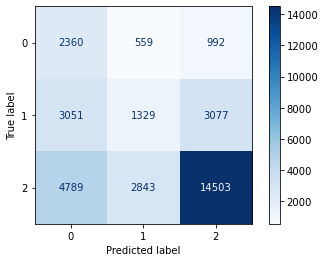

In [17]:
plot_confusion_matrix(GS, X_test, y_test, cmap=plt.cm.Blues) 
plt.show()